### Programa para la resolucion de Metodo Simplex

##### Michael Adolfo Huerta Ramírez

<br>
Maximize x₁ + x₂ subject to
<br>
x₁ ≥ 0
<br>
x₂ ≥ 0
<br>
-x₁ + x₂ ≤ 2
<br>
x₁ ≤ 4
<br>
x₂ ≤ 4
<br>


In [1]:
#las 3 posiciones extra en el arreglo ya incluye los valores de pivoteo

c = [1, 1, 0, 0, 0]
#aqui se incluyen los valores de pivoteo
A = [
    [-1, 1, 1, 0, 0],
    [ 1, 0, 0, 1, 0],
    [ 0, 1, 0, 0, 1]
]
#se muestran los valores para despues de la desigualdad
b = [2, 4, 4]

In [2]:
def to_tableau(c, A, b):
    #introduce el valor a utilizar
    xb = [eq + [x] for eq, x in zip(A, b)]
    print(xb)
    z = c + [0]
    print(z)
    return xb + [z]

In [3]:
#unimos el valor resultante de la desigualdad donde corresponse, para poder iterarlo más adelante
to_tableau(c,A,b)

[[-1, 1, 1, 0, 0, 2], [1, 0, 0, 1, 0, 4], [0, 1, 0, 0, 1, 4]]
[1, 1, 0, 0, 0, 0]


[[-1, 1, 1, 0, 0, 2],
 [1, 0, 0, 1, 0, 4],
 [0, 1, 0, 0, 1, 4],
 [1, 1, 0, 0, 0, 0]]

En esta parte los acomodamos en un arreglo unico cada una de las restricciones

In [4]:
def can_be_improved(tabla):
    z = tabla[-1]
    
    return any(x > 0 for x in z[:-1])

In [5]:
import math
import numpy as np

def get_pivot_position(tabla):
    z = tabla[-1]
    column = next(i for i, x in enumerate(z[:-1]) if x > 0)
    
    restrictions = []
    for eq in tabla[:-1]:
        el = eq[column]
        restrictions.append(math.inf if el <= 0 else eq[-1] / el)

    row = restrictions.index(min(restrictions))
    return row, column

In [6]:
def pivot_step(tabla, pivot_position):
    nueva_tabla = [[] for eq in tabla]
    
    i, j = pivot_position
    pivot_value = tabla[i][j]
    nueva_tabla[i] = np.array(tabla[i]) / pivot_value
    
    for eq_i, eq in enumerate(tabla):
        if eq_i != i:
            #aqui se pone el multiplicador de cada uno de los pasos de pivoteo
            multiplicador = np.array(nueva_tabla[i]) * tabla[eq_i][j]
            nueva_tabla[eq_i] = np.array(tabla[eq_i]) - multiplicador
   
    return nueva_tabla

In [7]:
def is_basic(columna):
    return sum(columna) == 1 and len([c for c in columna if c == 0]) == len(columna) - 1

def get_solution(tabla):
    columns = np.array(tabla).T
    soluciones = []
    for column in columns:
        solucion = 0
        if is_basic(column):
            one_index = column.tolist().index(1)
            solucion = columns[-1][one_index]
        soluciones.append(solucion)
        
    return soluciones

In [8]:
def simplex(c, A, b):
    tabla = to_tableau(c, A, b)

    while can_be_improved(tabla):
        pivot_position = get_pivot_position(tabla)
        tabla = pivot_step(tabla, pivot_position)

    return get_solution(tabla)

In [9]:
solution = simplex(c, A, b)
print('Solucion: ', solution)

[[-1, 1, 1, 0, 0, 2], [1, 0, 0, 1, 0, 4], [0, 1, 0, 0, 1, 4]]
[1, 1, 0, 0, 0, 0]
Solucion:  [4.0, 4.0, 2.0, 0, 0, 0]


Para poder visualizarlo ahora haremos lo siguiente: 

/Users/adolfohuerta/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


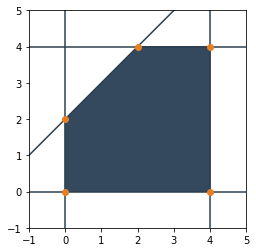

In [10]:
from scipy.spatial import HalfspaceIntersection, ConvexHull
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
halfspaces = [
    [-1, 0, 0],    # x₁ ≥ 0
    [0, -1, 0],    # x₂ ≥ 0
    [-1, 1, -2],   # -x₁ + x₂ ≤ 2
    [1, 0, -4],    # x₁ ≤ 4
    [0, 1, -4],    # x₂ ≤ 4
]
feasible_point = np.array([0.5, 0.5])
xlim = (-1, 5)
def render_inequalities(halfspaces, feasible_point, xlim, ylim):
    hs = HalfspaceIntersection(np.array(halfspaces), np.array(feasible_point))
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    x = np.linspace(*xlim, 100)

    for h in halfspaces:
        if h[1]== 0:
            ax.axvline(-h[2]/h[0], color="#2c3e50")
        else:
            ax.plot(x, (-h[2]-h[0]*x)/h[1], color="#2c3e50")
    x, y = zip(*hs.intersections)
    points = list(zip(x, y))
    convex_hull = ConvexHull(points)
    polygon = Polygon([points[v] for v in convex_hull.vertices], color="#34495e")
    ax.add_patch(polygon)
    ax.plot(x, y, 'o', color="#e67e22")
render_inequalities(halfspaces, feasible_point, xlim, xlim)
plt.show()

In [11]:
def simplex_with_visualization(c, A, b, halfspaces, feasible_point):
    tabla = to_tableau(c, A, b)

    soluciones = [get_solution(tabla)]
    while can_be_improved(tabla):
        pivot_position = get_pivot_position(tabla)
        tabla = pivot_step(tabla, pivot_position)
        soluciones.append(get_solution(tabla))
    
    points = [v[:2] for v in soluciones]
    xlim = (-1, max([p[0] for p in points]) + 1)
    ylim = (-1, max([p[1] for p in points]) + 1)
    render_inequalities(halfspaces, feasible_point, xlim, ylim)

    for start, end in zip(points[:-1], points[1:]):
        plt.arrow(
            start[0],
            start[1],
            end[0] - start[0],
            end[1] - start[1],
            width=0.1,
            length_includes_head=True,
            color='#1abc9c'
        )
    return get_solution(tabla)

[[-1, 1, 1, 0, 0, 2], [1, 0, 0, 1, 0, 4], [0, 1, 0, 0, 1, 4]]
[1, 1, 0, 0, 0, 0]


[4.0, 4.0, 2.0, 0, 0, 0]

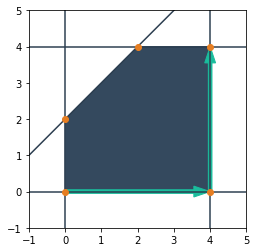

In [51]:
simplex_with_visualization(c, A, b, halfspaces, feasible_point)